# Detect chessboard

In [2]:

import matplotlib.pyplot as plt
import numpy as np

import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import plotly.express as px
import pickle

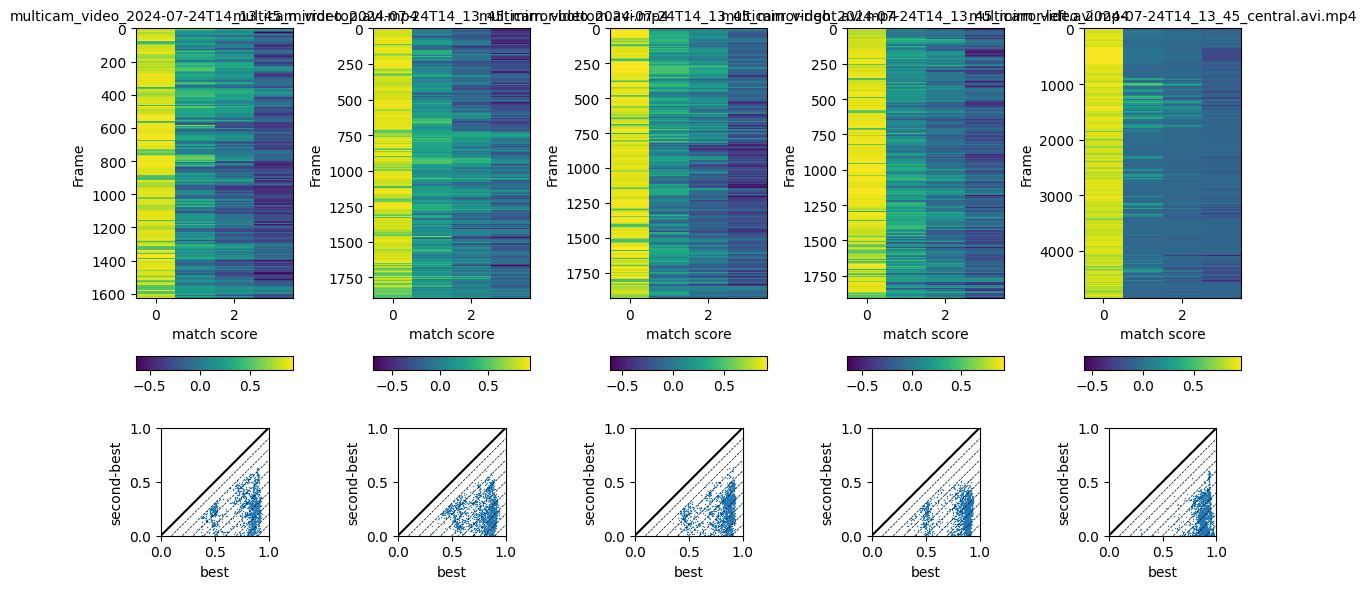

In [3]:
board_shape = (5, 7)
square_size = 12.5

# camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']
# prefix = '../../tests/example_data/example_calibration'
# data_dir = Path("/Users/vigji/Desktop/dest_dir/18042024")  # /Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped
#data_dir = Path(
#    r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056"
# )
# data_dir = Path("/Users/vigji/Desktop/test-anipose/cropped_calibration_vid")
data_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration')
video_paths = sorted([f for f in (data_dir.glob("Calibration/*/*.mp4")) if "overlay" not in f.stem])[::-1]
# camera_names = [p.stem.split("_")[-1].split(".detections")[0] for p in video_paths]

# video_paths = [str(f) for f in video_paths]


video_paths = [
    str(f) for f in data_dir.iterdir() if f.suffix == ".mp4" and "overlay" not in f.stem
]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths,
    mcc.detect_chessboard,
    n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5),
)

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
overlay = False
if overlay:
    for p in video_paths:
        mcc.overlay_detections(p, overwrite=True)
fig.savefig(data_dir / "checkerboard_errors.png")

# Calibrate

Check for Luigi:

- all_calib_uvs matrix when is created by the calibration images
- shape, dtype, filling values fror missed detections

All params passed to the mcc.calibrate function

In [4]:
all_calib_uvs.shape

(5, 14656, 35, 2)

## Initialization

In [5]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)
s = slice(None, None)
import flammkuchen as fl

fl.save(
    r"D:\SNeurobiology\Desktop\luigidelete\args_calibration.h5",
    dict(
        all_calib_uvs=all_calib_uvs[s],
        all_img_sizes=all_img_sizes[s],
        calib_objpoints=calib_objpoints,
    ),
)

In [6]:
all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs[:, s, :, :],
    all_img_sizes,
    calib_objpoints,
    root=0,
    n_samples_for_intrinsics=100,
)

Estimating camera intrinsics


100%|█████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]

Estimating camera extrinsics
Merging calibration object poses


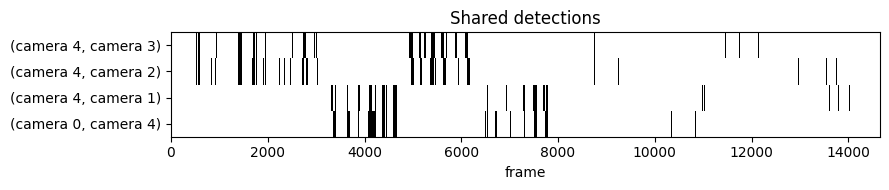

In [7]:
fig, shared_detections = mcc.plot_shared_detections(all_calib_uvs, spanning_tree)
# fig.savefig(data_dir / "shared_detections.png")

In [8]:
valid = (
    (~np.isnan(all_calib_uvs[1, :, 0, 0])) & (~np.isnan(all_calib_uvs[0, :, 0, 0]))
).astype(int)
np.sum(valid)

634

In [10]:
import tqdm
import cv2

n_cameras, n_frames, N, _ = all_calib_uvs.shape
median_error = np.zeros(n_cameras)
reprojections = np.zeros((n_cameras, n_frames, N, 2))
transformed_reprojections = np.zeros((n_cameras, n_frames, N, 2)) * np.nan
pts = mcc.embed_calib_objpoints(calib_objpoints, calib_poses)

errors_list = []
for cam in tqdm.trange(n_cameras):
    print(pts.shape)
    print(all_extrinsics[cam].shape)
    reprojections[cam] = mcc.project_points(
        pts, all_extrinsics[cam], all_intrinsics[cam][0]
    )
    uvs_undistorted = mcc.undistort_points(all_calib_uvs[cam], *all_intrinsics[cam])
    valid_ixs = np.nonzero(~np.isnan(uvs_undistorted).any((-1, -2)))[0]
    for t in valid_ixs:
        H = cv2.findHomography(uvs_undistorted[t], calib_objpoints[:, :2])
        transformed_reprojections[cam, t] = cv2.perspectiveTransform(
            reprojections[cam, t][np.newaxis], H[0]
        )[0]

    errors = np.linalg.norm(
        transformed_reprojections[cam, valid_ixs] - calib_objpoints[:, :2],
        axis=-1,
    )
    median_error[cam] = np.median(errors)
    errors_arr = np.zeros(n_frames) * np.nan
    errors_arr[valid_ixs] = np.median(errors, axis=1)
    errors_list.append(errors_arr)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:00,  7.46it/s]

(14656, 35, 3)
(6,)
(14656, 35, 3)
(6,)


 60%|██████    | 3/5 [00:00<00:00,  6.29it/s]

(14656, 35, 3)
(6,)
(14656, 35, 3)
(6,)


 80%|████████  | 4/5 [00:00<00:00,  6.45it/s]

(14656, 35, 3)
(6,)


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


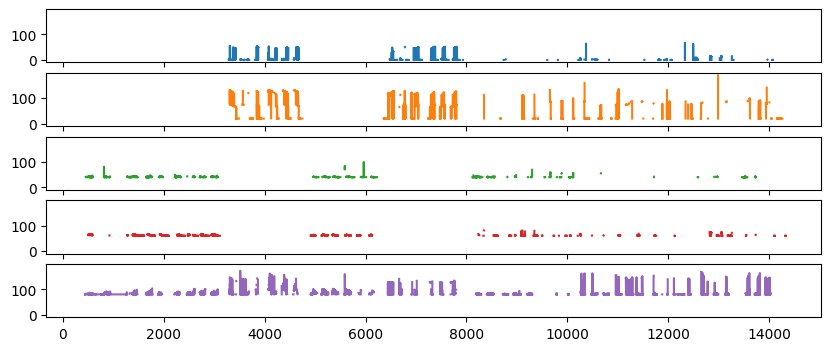

In [12]:
f, axs = plt.subplots(len(errors_list), 1, figsize=(10, 4), sharex=True, sharey=True)

for i, errors in enumerate(errors_list):
    axs[i].plot(errors + i * 20, c=f"C{i}")
# plt.plot(errors_list[0].mean(1))

100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


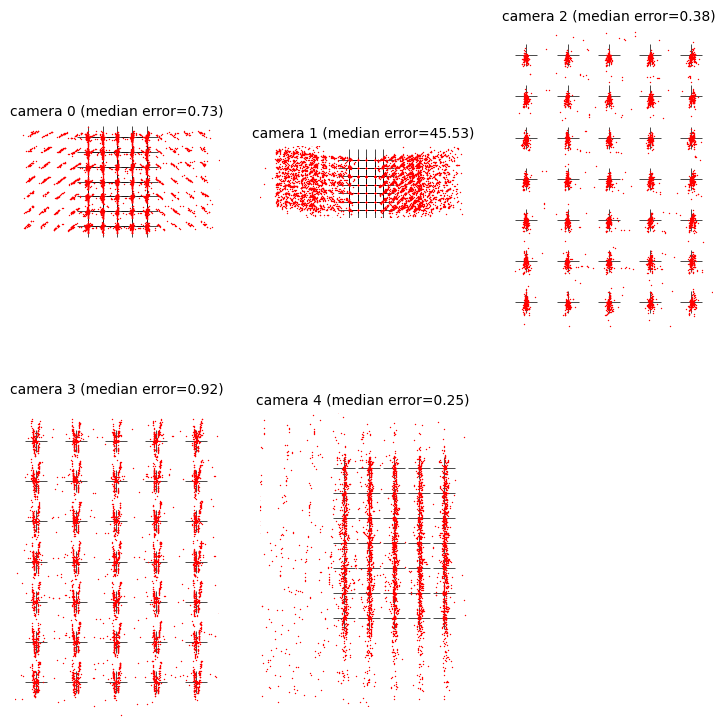

In [13]:
#    cam_names=['top', 'side1', 'side2', 'side3', 'side4', 'bottom'],
s = slice(0, None)
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:, s, :, :],
    all_extrinsics,
    all_intrinsics,
    calib_objpoints,
    calib_poses[s, :],
    inches_per_axis=3,
)
# fig.savefig(data_dir / "first_residuals.png")

## Bundle adjustment

In [14]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = mcc.bundle_adjust(
    all_calib_uvs,
    all_extrinsics,
    all_intrinsics,
    calib_objpoints,
    calib_poses,
    n_frames=None,
    ftol=1e-4,
)

Excluding 1161 out of 1744 frames based on an outlier threshold of 16.83295657201963
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7709e+05                                    1.27e+07    
       1              7         2.0800e+05      1.69e+05       1.92e+02       8.92e+06    
       2              8         1.6736e+05      4.06e+04       1.48e+02       4.32e+06    
       3              9         1.4839e+05      1.90e+04       1.76e+02       4.36e+06    
       4             10         1.2286e+05      2.55e+04       4.46e+01       3.78e+06    
       5             11         1.0544e+05      1.74e+04       7.09e+01       3.17e+06    
       6             12         9.8221e+04      7.22e+03       6.42e+01       2.56e+06    
       7             13         8.9345e+04      8.88e+03       7.20e+01       2.46e+06    
       8             14         8.6666e+04      2.68e+03       7.68e+01       1.98e+06    
     

In [15]:
nan_counts = np.isnan(all_calib_uvs).sum((0, 1, 2, 3))

  0%|          | 0/5 [00:00<?, ?it/s]/Users/thomasbush/miniconda3/envs/3d_setup/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbush/miniconda3/envs/3d_setup/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 5/5 [00:00<00:00, 18.01it/s]
/Users/thomasbush/miniconda3/envs/3d_setup/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ValueError: Axis limits cannot be NaN or Inf

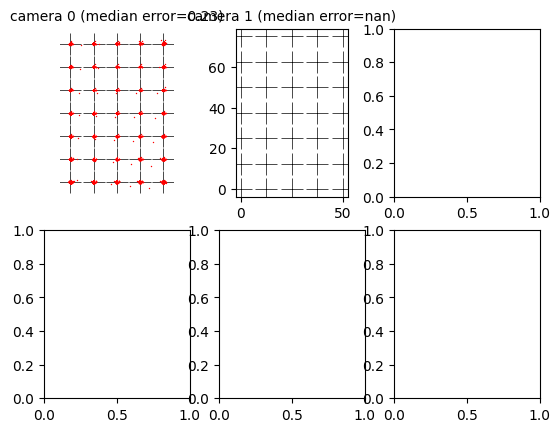

In [16]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:, use_frames],
    adj_extrinsics,
    adj_intrinsics,
    calib_objpoints,
    adj_calib_poses,
    inches_per_axis=3,
)
# fig.savefig(data_dir / "refined_residuals.png")

In [19]:
# Write calibration to anipose-compatible TOML format:
cam_names = [Path(p).stem.split("_")[-1].split(".avi")[0] for p in video_paths]
calibration_dict = dict()
for i, (cam_name, img_size, extrinsic, intrinsic) in enumerate(zip(cam_names, all_img_sizes, adj_extrinsics, adj_intrinsics)):
    cam_dict = dict(
        name=cam_name,
        size=img_size.tolist(),
        matrix=intrinsic[0].tolist(),
        distortions=extrinsic[1].tolist(),
        rotation=extrinsic[:3].tolist(),
        translation=extrinsic[3:].tolist()
    )
    calibration_dict[f"cam_{i}"] = cam_dict
calibration_dict["metadata"] = dict(adjusted=True, error=float(result.cost))

# Convert to TOML format
# import toml
# with open(data_dir / "calibration_from_mc.toml", "w") as f:
#     toml.dump(calibration_dict, f)


In [18]:
calib_uvs.shape

NameError: name 'calib_uvs' is not defined

In [23]:
all_calib_uvs.shape

(5, 14656, 35, 2)

In [20]:
def triangulate_all_keypoints(
    calib_uvs, adj_extrinsics, adj_intrinsics, progress_bar=True
):
    all_triang = []
    progbar = tqdm if progress_bar else lambda x: x
    for i in progbar(range(calib_uvs.shape[2])):
        all_triang.append(
            mcc.triangulate(calib_uvs[:, :, i, :], adj_extrinsics, adj_intrinsics)
        )

    return np.array(all_triang)


checkboard_3d = triangulate_all_keypoints(all_calib_uvs, adj_extrinsics, adj_intrinsics)

non_nan_idxs = np.where(~np.isnan(checkboard_3d).any(axis=(0, 2)))[0]
frame_idx = non_nan_idxs[0]
checkboard_frame = checkboard_3d[:, frame_idx, :]

TypeError: 'module' object is not callable

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(checkboard_frame[:, 0], checkboard_frame[:, 1], checkboard_frame[:, 2])

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
plt.axis("equal")
plt.show()

In [ ]:
file = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_20241111-164517.json"

import json

with open(file) as f:
    d = json.load(f)
    print(d)
coordinates = d[-1]
coordinates_ars = {}
for key, value in coordinates["points_coordinate"].items():
    coordinates_ars[key] = np.array(value)

right_arr = [
    coordinates_ars[cam] for cam in camera_sequence
]  # [coordinates_ars['central'], coordinates_ars['mirror-bottom'], coordinates_ars['mirror-left'], coordinates_ars['mirror-right'], coordinates_ars['mirror-top']]
right_arr = np.stack([np.expand_dims(np.array(arr), 0) for arr in right_arr], 0)

arena_3d = triangulate_all_keypoints(
    right_arr[:, :, :, [1, 0]], adj_extrinsics, adj_intrinsics
)
# arena_triangulation = []
# for i in tqdm(range(8)):
#     arena_triangulation.append(mcc.triangulate(right_arr2[:, :, i, [1, 0]], adj_extrinsics, adj_intrinsics))
# arena_triangulation = np.array(arena_triangulation).squeeze()
arena_frame = arena_3d[:, 0, :]

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(projection="3d")


ax.scatter(
    checkboard_frame[:, 0], checkboard_frame[:, 1], checkboard_frame[:, 2], c="b"
)
ax.scatter(arena_frame[:, 0], arena_frame[:, 1], arena_frame[:, 2], c="r")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
plt.axis("equal")
plt.show()

## check backprojections for frame

Get the coordinats of the arean on the image 

In [126]:
back_projections = {}
names = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]
for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    back_projections[names.pop(0)] = mcc.project_points(
        arena_frame, extrinsic, intrinsic[0], dist_coefs=intrinsic[1]
    )

Get the coordinates of the checkboard on the image plane for each camera view

In [ ]:
all_triang.shape

In [129]:
names = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]
checkboard_back_projections = {}

for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    checkboard_back_projections[names.pop(0)] = mcc.project_points(
        checkboard_frame, extrinsic, intrinsic[0], dist_coefs=intrinsic[1]
    )

In [130]:
# get the same frame from all the videos:
import cv2

idx = frame_idx
frames = {}
names = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]
for frame, name in zip(video_paths, names):
    cap = cv2.VideoCapture(str(frame))
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    res, frame = cap.read()
    frames[name] = frame

In [ ]:
plt.figure(figsize=(10, 10))

for i, view in enumerate(camera_sequence):
    plt.subplot(2, 3, i + 1)
    plt.imshow(frames[view], cmap="gray")
    plt.scatter(back_projections[view][:, 0], back_projections[view][:, 1], c="r", s=10)
    plt.scatter(
        checkboard_back_projections[view][:, 0],
        checkboard_back_projections[view][:, 1],
        c="b",
        s=10,
    )
    plt.title(view)

plt.show()

Backprojections without dist_coef

In [71]:
back_projections_nodist = {}
names = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]
for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    back_projections_nodist[names.pop(0)] = mcc.project_points(
        arena_triangulation, extrinsic, intrinsic[0], dist_coefs=None
    )

In [72]:
names = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]
checkboard_back_projections_nodist = {}

for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    checkboard_back_projections_nodist[names.pop(0)] = mcc.project_points(
        checkboard_3d, extrinsic, intrinsic[0], dist_coefs=None
    )

## plot tracked points and arean together

In [135]:
with open(
    r"C:\Users\SNeurobiology\code\3d-setup\notebooks\tracked_points_sample.pkl", "rb"
) as f:
    tracked_points = pickle.load(f)

In [ ]:
tracked_points_3d = triangulate_all_keypoints(
    tracked_points, adj_extrinsics, adj_intrinsics
)

In [ ]:
tracked_points_3d.shape

In [139]:
tracked_points_idx = 18966
tracked_points_3d_frame = tracked_points_3d[:, tracked_points_idx, :]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(
    tracked_points_3d_frame[:, 0],
    tracked_points_3d_frame[:, 1],
    tracked_points_3d_frame[:, 2],
    c="b",
)
ax.scatter(arena_frame[:, 0], arena_frame[:, 1], arena_frame[:, 2], c="r")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
plt.axis("equal")
plt.show()

In [ ]:
all_calib_uvs.shape

In [188]:
# save arena_points, tracked_points for testing
data = {
    "arena_coordinates": right_arr,
    "tracked_points": tracked_points[:, :200, :, :],
    "checkboard_points": all_calib_uvs[:, :200, :, :],
}
calib_data = {
    "points": data,
    "extrinsics": adj_extrinsics,
    "intrinsics": adj_intrinsics,
}
pickle.dump(calib_data, open(r"../tests/assets/arena_tracked_points.pkl", "wb"))

## try scripts functions:

In [172]:
import os
import sys

sys.path.append("../threed_utils")

In [180]:
from triangulation import triangulate_all_keypoints, back_project_points
from visualization import plot_triangulations, plot_back_projections

In [ ]:
# get triangulations
arena_test_triang = triangulate_all_keypoints(right_arr, adj_extrinsics, adj_intrinsics)

In [ ]:
arena_test_triang.shape

In [ ]:
back_projection_test = back_project_points(
    arena_test_triang, adj_extrinsics, adj_intrinsics, camera_sequence
)

## function to back-project triangulation

# Visualisation

In [2]:
import plotly.graph_objects as go
from IPython.display import display, clear_output
import time

In [3]:
with open('../tests/assets/arena_tracked_points.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
tracked_3d_sample = data['points']['tracked_points']

In [ ]:
tracked_3d_sample.shape

In [14]:
arena_frame = data['points']['arena_coordinates']

In [60]:
# define skeleton: define the connections between the lower part and the top part

skeleton = [(0, 1), (0, 2), (5, 3), (5, 4), (8, 6), (8, 7), (10, 11), (11, 12), (12, 9), (1, 10), (2, 10), (10, 5), (8, 12)]

In [76]:
def plot_single_frame(pose, skeleton, arena):
    fig = go.Figure()

    fig.add_traces(go.Scatter3d(
        x=pose[:, 0], y=pose[:, 1], z=pose[:, 2], mode='markers', marker=dict(size=5, color='blue'), name='tracked points'
    ))
    skeleton_color = 'gray'
    for start, finish in skeleton:
        fig.add_traces(go.Scatter3d(
            x=[pose[start, 0], pose[finish, 0]], y=[pose[start, 1], pose[finish, 1]], z=[pose[start, 2], pose[finish, 2]], mode='lines', line=dict(width=2, color=skeleton_color) ,  name='skeleton'
        ))

    fig.add_traces(go.Mesh3d(
        x = arena[:, 0], y = arena[:, 1], z = arena[:, 2], color='lightpink', opacity=0.5, name='arena', alphahull=0
    ))

    # fig.update_layout(scene=dict(
    #     xaxis=dict(nticks=4, range=[-1, 4], title='X'),
    #     yaxis=dict(nticks=4, range=[-1, 4], title='Y'),
    #     zaxis=dict(nticks=4, range=[-1, 4], title='Z'),
    # ))
    fig.update_layout(margin=dict(r=0, l=0, b=0, t=0))
    return fig 




In [ ]:
arena_frame.shape

In [17]:
adj_extrinsics = data['extrinsics']
adj_intrinsics = data['intrinsics']

In [ ]:
from threed_utils.triangulation import triangulate_all_keypoints

arena_triangulation = triangulate_all_keypoints(arena_frame[:, :, :, [1, 0]], adj_extrinsics, adj_intrinsics)

In [ ]:
tracked_points_sample = triangulate_all_keypoints(tracked_3d_sample, adj_extrinsics, adj_intrinsics)

In [ ]:
arena_triangulation.shape

In [ ]:
fig = plot_single_frame(tracked_points_sample[:, 20, :], skeleton, arena_triangulation.squeeze())
fig.show()


In [79]:
for i in [20, 40, 60, 100, 150, 196]:
    fig = plot_single_frame(tracked_points_sample[:, i, :], skeleton, arena_triangulation.squeeze())
    fig.write_html('tracked_points_sample_frame{i}.html'.format(i=i))

In [47]:
import ipywidgets as widgets
import threading
import asyncio


In [ ]:
tracked_points_sample.shape

In [ ]:
def plot_single_frame(pose, skeleton, arena):
    fig = go.Figure()

    fig.add_traces(go.Scatter3d(
        x=pose[:, 0], y=pose[:, 1], z=pose[:, 2], mode='markers', marker=dict(size=5, color='blue'), name='tracked points'
    ))
    skeleton_color = 'gray'
    for start, finish in skeleton:
        fig.add_traces(go.Scatter3d(
            x=[pose[start, 0], pose[finish, 0]], y=[pose[start, 1], pose[finish, 1]], z=[pose[start, 2], pose[finish, 2]], mode='lines', line=dict(width=2, color=skeleton_color) ,  name='skeleton'
        ))

    fig.add_traces(go.Mesh3d(
        x = arena[:, 0], y = arena[:, 1], z = arena[:, 2], color='lightpink', opacity=0.5, name='arena', alphahull=0
    ))

    # fig.update_layout(scene=dict(
    #     xaxis=dict(nticks=4, range=[-1, 4], title='X'),
    #     yaxis=dict(nticks=4, range=[-1, 4], title='Y'),
    #     zaxis=dict(nticks=4, range=[-1, 4], title='Z'),
    # ))
    fig.update_layout(margin=dict(r=0, l=0, b=0, t=0))
    return fig



frame_slider = widgets.IntSlider(min=0, max=tracked_points_sample.shape[1] - 1, step=1, value=0, descroption='Frame')
play_button = widgets.ToggleButton(value=False, description='Play', icon='play')

is_playing = False

def update_plot(change):
    frame = frame_slider.value
    fig = plot_single_frame(tracked_points_sample[:, frame, :], skeleton, arena_triangulation.squeeze())
    clear_output(wait=True)
    display(frame_slider, play_button)
    fig.show()


async def play_frames():
    while play_button.value and frame_slider.value < tracked_points_sample.shape[1] -1:
        frame_slider.value += 1
        await asyncio.sleep(1.5)

# def play_frames():
#     global is_playing
#     while is_playing and frame_slider.value < tracked_points_sample.shape[1] -1:
#         frame_slider.value += 1
#         time.sleep(0.2)
#     is_playing = False
#     play_button.value = False

def toggle_play(change):
    if change['new']:
        asyncio.create_task(play_frames())
    else:
        play_button.value = False


# def toggle_play(change):
#     global is_playing
#     if change['new']:
#         play_thread = threading.Thread(target=play_frames)
#         play_thread.start()
#     else:
#         is_playing = False


frame_slider.observe(update_plot, names='value')
play_button.observe(toggle_play, names='value')

display(frame_slider, play_button)
update_plot(None)



In [ ]:
# plotly animators:
animato_frames = []





for frame_idx in range(tracked_points_sample.shape[1]):

    scatter = go.Scatter3d(
        x=tracked_points_sample[:, frame_idx, 0], y=tracked_points_sample[:, frame_idx, 1], z=tracked_points_sample[:, frame_idx, 2],
        mode='markers', marker=dict(size=5, color='blue'), name='tracked points'
    )

    lines = []
    for start, finish in skeleton:
        lines.append(go.Scatter3d(
            x=[tracked_points_sample[start, frame_idx, 0], tracked_points_sample[finish, frame_idx, 0]],
            y=[tracked_points_sample[start, frame_idx, 1], tracked_points_sample[finish, frame_idx, 1]],
            z=[tracked_points_sample[start, frame_idx, 2], tracked_points_sample[finish, frame_idx, 2]],
            mode='lines', line=dict(width=2, color='gray'), name='skeleton'
        ))

    arena_mesh = go.Mesh3d(
    x = arena_triangulation.squeeze()[:, 0], y = arena_triangulation.squeeze()[:, 1], z = arena_triangulation.squeeze()[:, 2], color='lightpink', opacity=0.5, name='arena', alphahull=0
)

    animato_frames.append(go.Frame(data=[scatter, arena_mesh] + lines, name = str(frame_idx)))

fig = go.Figure(data=[animato_frames[0].data[0], animato_frames[0].data[1]] + list(animato_frames[0].data[2:]))


# fig.add_trace(animato_frames[0].data[0])
# for line in animato_frames[0].data[1:]:
#     fig.add_trace(line)



fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(label='Play',
                      method='animate',
                      args = [None, {'frame':{'duration':200, 'redraw':True},
                                     'fromcurrent':True, 'mode':'immediate'}]),
                                     dict(label='pause', 
                                          method='animate',
                                          args=[None, {'frame':{'duration':0, 'redraw':True},
                                                       'mode':'immediate'}])]
    )])

fig.frames = animato_frames
fig.show()



# Save results

In [15]:
# save for JARVIS
camera_names = ["bottom", "side1", "side2", "side3", "side4"]
video_dir = data_dir / "calibration_vals"
save_path = f"{video_dir}/CalibrationParameters/"
mcc.save_calibration(
    all_extrinsics, all_intrinsics, camera_names, save_path, save_format="jarvis"
)

# save for GIMBAL
save_path = f"{video_dir}/camera_params.h5"
mcc.save_calibration(
    all_extrinsics, all_intrinsics, camera_names, save_path, save_format="gimbal"
)
# save for GIMBAL
save_path = f"{video_dir}/camera_params_adj.h5"
mcc.save_calibration(
    adj_extrinsics, adj_intrinsics, camera_names, save_path, save_format="gimbal"
)

In [5]:
save_path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240801\Calibration\multicam_video_2024-08-01T18_03_33_cropped_20240923170906\calibration_vals\camera_params_adj.h5"

## Triangulation

In [6]:
data = mcc.load_calibration(save_path, load_format="gimbal")

In [7]:
all_extrinsics, all_intrinsics, camera_names = data

In [ ]:
[all_intrinsic[1] for all_intrinsic in all_intrinsics]

In [146]:
import pickle

with open(
    r"C:\Users\SNeurobiology\code\3d-setup\notebooks\tracked_points_sample.pkl", "rb"
) as f:
    tracked_points = pickle.load(f)

In [ ]:
tracked_points.shape

In [ ]:
all_extrinsics, all_intrinsics = np.array(all_extrinsics), np.array(all_intrinsics)

In [ ]:
(adj_extrinsics * 1000).astype(int)

In [ ]:
(all_extrinsics * 1000).astype(int)

In [ ]:
# triangulation:
i = 18966
point_01 = tracked_points[:, i : i + 1, ...]
point_01.shape

In [ ]:
# concatenated_arr = [np.expand_dims(np.array(arr), 0) for arr in point_01]
# right_arr = np.stack(concatenated_arr, axis=0)

all_triang = []
for i in tqdm(range(tracked_points.shape[2])):
    all_triang.append(
        mcc.triangulate(point_01[:, :, i, [1, 0]], all_extrinsics, all_intrinsics)
    )
all_triang = np.array(all_triang)
data = all_triang
data = data.reshape(13, 3)

In [ ]:
postural_names = [
    "nose",
    "Lear",
    "Rear",
    "LFlimb",
    "RFlimb",
    "FLimbMid",
    "LBlimb",
    "RBlimb",
    "BLimbMid",
    "tailbase",
    "UpperForward",
    "UpperMid",
    "UpperBack",
]


fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    arena_triangulation[:, 0],
    arena_triangulation[:, 1],
    arena_triangulation[:, 2],
    c="blue",
    marker="o",
    label="arena",
    s=10,
)


ax.scatter(
    data[:, 0], data[:, 1], data[:, 2], c="red", marker="^", label="triangulated", s=10
)

for i, name in enumerate(postural_names):
    ax.text(data[i, 0], data[i, 1], data[i, 2], name, color="black", fontsize=8)

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.legend()

plt.show()

In [ ]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i in range(10):
    off = 8000 + i * 10
    ax.scatter(all_triang[:, off, 0], all_triang[:, off, 1], all_triang[:, off, 2])
# ax.scatter(all_triang[:, ::100, 0].flatten(),
#            all_triang[:, ::100, 1].flatten(),
#            all_triang[:, ::100, 2].flatten() )
set_axes_equal(ax)

## Check arean coordinates, plot arena 3d, sanaty check

In [ ]:
file = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_20241108-143350.json"

import json

with open(file) as f:
    d = json.load(f)
    print(d)
coordinates = d[-1]
coordinates_ars = {}
for key, value in coordinates["points_coordinate"].items():
    coordinates_ars[key] = np.array(value)

all_arr = list(coordinates["points_coordinate"].values())
concatenated_arr = [np.expand_dims(np.array(arr), 0) for arr in all_arr]
right_arr = np.stack(concatenated_arr, axis=0)

arena_triangulation = []
for i in tqdm(range(8)):
    arena_triangulation.append(
        mcc.triangulate(right_arr[:, :, i, [1, 0]], all_extrinsics, all_intrinsics)
    )
arena_triangulation = np.array(arena_triangulation).squeeze()

In [223]:
coordinates = d[-1]

### check points arena over frames

In [86]:
coordinates_views = coordinates["points_coordinate"]

for key, value in coordinates_views.items():
    coordinates_views[key] = np.array(value)

In [ ]:
coordinates_views["central"][:, 0].shape

In [88]:
import os
import sys

sys.path.append("../complete_pipeline")
from utils import read_first_frame

In [96]:
# display each coordinate on the cropped image,
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


dir_path = Path(
    r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241108143758_recal"
)
first_frames = {}
names = ["central", "bottom", "left", "right", "top"]
a = -1
for i in dir_path.iterdir():
    if i.suffix == ".mp4":
        a += 1

        video_path = i
        first_frames[names[a]] = read_first_frame(str(video_path))

In [97]:
first_frames_n = {}
for value, key in zip(first_frames.values(), coordinates_views.keys()):
    first_frames_n[key] = value

In [ ]:
first_frames_n.keys()

In [ ]:
coordinates_views.keys()

In [ ]:
plt.clf()

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.imshow(first_frames_n["central"], cmap="gray")
plt.scatter(
    coordinates_views["central"][:, 1], coordinates_views["central"][:, 0], c="r", s=10
)
plt.title("central")


plt.subplot(3, 2, 2)
plt.imshow(first_frames_n["mirror-bottom"], cmap="gray")
plt.scatter(
    coordinates_views["mirror-bottom"][:, 1],
    coordinates_views["mirror-bottom"][:, 0],
    c="r",
    s=10,
)
plt.title("bottom")


plt.subplot(3, 2, 3)
plt.imshow(first_frames_n["mirror-left"], cmap="gray")
plt.scatter(
    coordinates_views["mirror-left"][:, 1],
    coordinates_views["mirror-left"][:, 0],
    c="r",
    s=10,
)
plt.title("left")

plt.subplot(3, 2, 4)
plt.imshow(first_frames_n["mirror-right"], cmap="gray")
plt.scatter(
    coordinates_views["mirror-right"][:, 1],
    coordinates_views["mirror-right"][:, 0],
    c="r",
    s=10,
)
plt.title("right")

plt.subplot(3, 2, 5)
plt.imshow(first_frames_n["mirror-top"], cmap="gray")
plt.scatter(
    coordinates_views["mirror-top"][:, 1],
    coordinates_views["mirror-top"][:, 0],
    c="r",
    s=10,
)
plt.title("top")

plt.show()

### plot triangulation arean

In [234]:
coordinates_ars = {}
for key, value in coordinates["points_coordinate"].items():
    coordinates_ars[key] = np.array(value)

In [235]:
all_arr = list(coordinates["points_coordinate"].values())
concatenated_arr = [np.expand_dims(np.array(arr), 0) for arr in all_arr]
right_arr = np.stack(concatenated_arr, axis=0)

In [ ]:
all_triang1 = []
for i in tqdm(range(8)):
    all_triang1.append(
        mcc.triangulate(right_arr[:, :, i, [1, 0]], all_extrinsics, all_intrinsics)
    )
all_triang1 = np.array(all_triang1)

In [ ]:
all_triang1

In [ ]:
data

In [247]:
data = all_triang1
data_coordinates_arena = data.squeeze()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    x=data_coordinates_arena[:, 0],
    y=data_coordinates_arena[:, 1],
    z=data_coordinates_arena[:, 2],
    text=range(8),
)
plt.axis("equal")
fig.show()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(projection="3d")


ax.scatter(
    data_coordinates_arena[:, 0],
    data_coordinates_arena[:, 1],
    data_coordinates_arena[:, 2],
)

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
plt.axis("equal")
plt.show()

### Sanity Check

In [130]:
# plot the same point over each  frame to check for consistency
import pickle

coord_path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240803\M4\140337\right_coords.pkl"
with open(coord_path, "rb") as f:
    coordinates = pickle.load(f)

In [133]:
ars = [value for value in coordinates.values()]
uncropped_coordinates = np.stack(ars, axis=0)

In [ ]:
uncropped_coordinates[:, 0, :]

In [136]:
%gui qt5

In [141]:
import napari
from utils import read_first_frame

path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240803\M4\140337\multicam_video_2024-08-03T14_32_11.avi"
frame = read_first_frame(path)


def inspect_id(frame, i):
    viewer = napari.Viewer()
    viewer.add_image(frame, name="uncropped", contrast_limits=[0, 255])

    points_layer = viewer.add_points(
        uncropped_coordinates[:, i, :],
        size=10,
        name="points",
        edge_color="white",
        edge_width=0.5,
    )
    points_layer.editable = True

    napari.run()
    adjusted_points = points_layer.data

In [ ]:
for i in range(8):
    inspect_id(frame, i)

Here the identities of the points look fine (check only top bottom in central for left point)

Next steps for calibration correction:

- Check identity before cropping
- Check identity after cropping again
- Check if video for calibration are distorting the points

- check expected cameras and stack array